***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Function Test</span> 

# Helmholtz Machine Test on MNIST (Small Subset with CPU)


*Created:* March 3, 2025


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.is_available()

True

In [2]:
def para_init(n_dz,dev):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    return Phi,Theta

In [3]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [4]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [5]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [6]:
def log(p):
    q = torch.where(p != 0, torch.log(p), -20) # replace log(0) with -100
    return q

In [7]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * log(q) + (1-y) * log(1-q)).mean()
    return loss

In [8]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [9]:
def layer_wise_train(input_x,param_xy,param_yx,lr,perturb):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    perturb -- With probability 1/4 the sampled value is flipped. Boolean value True or False.
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    if perturb == True:
        output_y = (output_y + (torch.rand(output_y.size(),device=dev) < 1/4).long()).fmod(2)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [10]:
def wake_phase(Phi,Theta,data,lr,dev,perturb):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    perturb -- With probability 1/4 the sampled value is flipped. Boolean value True or False.
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,perturb)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [11]:
def wake_sample(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        input_x = sample(one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)]),dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample

In [12]:
def wake_phase_update(Phi,Theta,data,lr,dev,T,Eta):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,)
    lr -- learning rate
    dev -- torch device
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,perturb=False)
        
        # update cached items
        T['Layer'+str(i+1)] = (T['Layer'+str(i+1)] + output_y.reshape(-1,)*Eta[i])/(1+Eta[i])
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss, T

In [13]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr,perturb=False)
        input_x = output_y
    return Phi, Loss

In [14]:
def sleep_sample(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    for i in range(n_layer-1,0,-1):
        input_x = sample(one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)]),dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    return Gen_sample

In [15]:
def sleep_phase_update(Phi,Theta,lr,dev,T,Eta):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    lr -- learning rate
    dev -- torch device
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,1,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
        # update cached items
        T['Layer'+str(i-1)] = (T['Layer'+str(i-1)] + output_y.reshape(-1,)*Eta[i-1])/(1+Eta[i-1])
    return Phi, Loss, T

In [16]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = torch.zeros(n,dtype=int,device=dev)
    bnr = bnr.to('cpu').numpy()
    for i in range(n):
        binary = ''.join(bnr[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [17]:
def decimalize_np(bnr):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger numpy array in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = np.zeros(n,dtype=int)
    bnr = bnr.to('cpu').numpy()
    for i in range(n):
        binary = ''.join(bnr[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [18]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [19]:
def one_step_prob_matrix(n_x, param,dev):
    """
    Arguments:
    n_x -- number of neurons at input layer x
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    dev -- torch device
    
    Returns:
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y).
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y)
    """
    X = binarilize(np.arange(2**n_x),n_x,dev)  # (n_x,2**n_x)
    q = one_step_forward(X,param)   # (n_y,2**n_x)
    prob_ft = torch.t(q)  # (2**n_x,n_y)
    
    # categorical probability
    n_y = q.shape[0]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_x, 2**n_y,device=dev)
    for i in range(2**n_x):
        prob_ct[i,:] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    
    # Ursatz = 1
    if n_x == 1:
        prob_ft = prob_ft[1:,:]
        prob_ct = prob_ct[1:,:]
    return prob_ft, prob_ct

\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = \sigma\Big(\sum_{i=1}^n \mathrm{w}_{ij} \mathrm{x}_i - \sum_{i=1}^n\mathrm{x}_i^2 \cdot \gamma \big(p_j - \mathrm{y}_j\big)\Big)
\end{equation}
Linear approximation:
\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j)
\end{equation}

In [20]:
def increment(input_x, param, lr,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    eps -- Estimated hyperparameter epsilon
    """
    linear = torch.matmul(param,input_x.type(torch.float)) # (n_y,batch_size)
    p = sigmoid(linear) # (n_y,batch_size)
    linear_update_0 = linear - input_x.sum(axis=0,keepdim=True)*lr*p
    linear_update_1 = linear - input_x.sum(axis=0,keepdim=True)*lr*(p-1)
    p_add_0 = sigmoid(linear_update_0)
    p_add_1 = sigmoid(linear_update_1)
    eps0 = (p - p_add_0)/(p+1e-8)  # (n_y,batch_size)
    eps1 = (p - p_add_1)/(p-1+1e-8)
    eps = (eps0 + eps1)/2
#     print(eps0,eps1)
    eps = eps.mean()
    return eps

In [21]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * log(p)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * log(P)).sum(axis=1,keepdims=True)
    return H

In [22]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber * log(P_ber) + (1-P_ber) * log(1-P_ber))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [23]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*log(q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [24]:
def KL_divergence_inclusive(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*torch.where(q != 0, torch.log(q), 0)).sum() # q=0, log(q)=0
    else:
        raise Exception('Dimension error')
    return D_KL

In [25]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*log(p) - p*log(q) + (1-p)*log(1-p) - (1-p)*log(1-q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [26]:
def one_step_prob_entropy(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    p_y -- Bernoulli probability of each neuron at layer Y. Torch tensor of shape (n_y,)
    H_Y -- factorial entropy at output layer Y, a tensor number
    I -- mutual information between layers X and Y, a tensor number
    """
    p_yx = q.t()   # (batch_size,n_y)
    H_YX = entropy_bernoulli(p_yx).mean() # tensor number
    p_y = p_yx.mean(axis=0) # (n_y,)
    H_Y = entropy_bernoulli(p_y) # tensor number
    I = H_Y - H_YX
    return H_Y, I

In [27]:
def wake_entropy(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    H_Y_wake -- factorial entropy at layers 1,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_wake -- mutual information between layers [0,1],...,[n_layer-3,n_layer-2]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Phi) + 2
    H_Y_wake = torch.zeros(n_layer-2)
    I_wake = torch.zeros(n_layer-2)
    input_x = data
    for i in range(n_layer-2):
        q = one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        H_Y_wake[i], I_wake[i] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    return H_Y_wake, I_wake

In [28]:
def sleep_entropy(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    H_Y_sleep -- factorial entropy at layers 0,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_sleep -- mutual information between layers [1,0],...,[n_layer-2,n_layer-3]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Theta) + 1
    H_Y_sleep = torch.zeros(n_layer-1)
    I_sleep = torch.zeros(n_layer-1)
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    for i in range(n_layer-1,0,-1):
        q = one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        H_Y_sleep[i-1], I_sleep[i-1] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    I_sleep = I_sleep[:-1]
    return H_Y_sleep, I_sleep

### 1. $H(Y|x)$

\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j) = (1-\epsilon) p_j + \epsilon \mathrm{y}_j,  \qquad \mathrm{y}_j = \{0,1\}
\end{equation}

In [29]:
def conditional_entropy(x,param,eps,dev):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    H_Yx -- conditional entropy H_Yx at output layer Y, torch tensor of shape (2, n_y)
    """
    q = one_step_forward(x,param).reshape(-1,) # (n_y,)
    n_y = len(q)
    q_add = torch.zeros(2,n_y,device=dev) # p_j+1 of y_j = 0 (row1) and y_j = 1 (row2)
    q_add[0,:] = (1-eps) * q
    q_add[1,:] = (1-eps) * q + eps
    H_Yx = -(q_add*log(q_add) + (1-q_add)*log(1-q_add)) # (2,n_y)
    return H_Yx

### 2. $H(Y)_{ft}$

\begin{equation}
\mathbf{t} = \begin{pmatrix}
   \mathrm{p_1};&  \mathrm{p_2};&  \ldots;&  \mathrm{p_m}
    \end{pmatrix} 
\end{equation}
$\mathrm{p_j}$'s are Bernoulli probabilities.

\begin{equation}
    \mathrm{p_j}^{+1}(\mathrm{y}_j) = \left \{
    \begin{array}{ll}
     \frac{\mathrm{p_j} + \eta}{1+\eta},  &  \text{if } \mathrm{y}_j = 1\\
     \frac{\mathrm{p_j}}{1+\eta},   & \text{if } \mathrm{y}_j = 0
    \end{array}
    \right. \label{epsilon modify}
\end{equation}

In [30]:
def factorial_entropy(t,eta,dev):
    """
    Arguments:
    t -- Multi-variate Bernoulli distribution (p_1;p_2;...p_{n_y}), torch tensor of shape (n_y,)
    eta -- eta, hyperparameter of eta = eps/(1-eps)
    dev -- device
    
    Returns:
    H_ft -- factorial entropy H_ft at output layer Y, torch tensor of shape (2,n_y)
    """
    n_y = len(t)
    p_add = torch.zeros(2,n_y,device=dev) # p+1 of y_j = 0 (row1) and y_j = 1 (row2)
    p_add[0,:] = t/(1+eta)
    p_add[1,:] = (t+eta)/(1+eta)
    H_ft = -(p_add*log(p_add) + (1-p_add)*log(1-p_add)) # (2,n_y)
    return H_ft

In [31]:
def MI_max(I):
    """
    Argument: I -- mutual information, torch tensor of shape (2,n_y)
    Return: index -- sampled index, torch tensor of shape (n_y,)
    """
    index = I.argmax(dim=0)
    return index

In [32]:
def MI_train(input_x,param_xy,param_yx,lr,H_Y,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,1)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    H_Y -- entropy H(Y). Comnination of H_ct_state and H_ft_state
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # H_Yx
    H_Yx = conditional_entropy(input_x,param_xy,eps,dev) # (2**n_y,)

    # Compute mutual information
    I = H_Y - H_Yx
   
    # Maximum I
    output_y = MI_max(I).reshape(-1,1)  # (n_y,1)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return I, output_y, param_yx, grad, loss

In [33]:
def wake_phase_MI(Phi,Theta,data,lr,T,Epsilon,Eta,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        # H_ft
        H_Y = factorial_entropy(T['Layer'+str(i+1)],Eta[i],dev)

        # layer-wise training
        I, output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        MI_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,H_Y,Epsilon[i],dev)
        
        # update cached items
        T['Layer'+str(i+1)] = (T['Layer'+str(i+1)] + output_y.reshape(-1,)*Eta[i])/(1+Eta[i])
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss, T

In [34]:
def initialize_MI(data,Phi,lr,dev):
    """
    Arguments:
    data -- input dataset, torch tensor of shape (n_d, batch_size)
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    lr -- learning rate
    dev -- torch device
    
    Returns:
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    Delta -- hyperparameter O(eta/2^(m-1)), torch tensor of shape (n_layer-2,)
    """
    T = {}
    Epsilon = torch.zeros(n_layer-2,device=dev)
    batch_size = data.shape[1]
    Recog_sample = wake_sample(Phi,data,dev)
    for i in range(n_layer-2):
        input_x = Recog_sample["Layer_" + str(i)]  #(n_x, batch_size)
        Epsilon[i] = increment(input_x, Phi["Phi_" + str(i) + str(i+1)], lr,dev)
        
        y_sample = Recog_sample["Layer_" + str(i+1)] #(n_y, batch_size)
        T['Layer'+str(i+1)] = y_sample.sum(axis=1)/batch_size
        
    Eta = Epsilon/(1-Epsilon) # H_ft; eta = eps/(1-eps)
    return T,Epsilon,Eta

## MNIST Data "0"

- $28 \times 28$ images of handwritten "0".

In [35]:
from torchvision import datasets, transforms

In [36]:
dev = torch.device("cpu") # operate on GPU "cuda" or CPU "cpu"

In [37]:
# Define the transformation to convert images to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.to(dev))])
# Load the MNIST dataset with the specified transformation
mnist_pytorch = datasets.MNIST(root='D:\deep music\MNIST', train=True, download=False, transform=transform)
mnist_pytorch

Dataset MNIST
    Number of datapoints: 60000
    Root location: D:\deep music\MNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )

In [38]:
train_loader_pytorch = torch.utils.data.DataLoader(mnist_pytorch, batch_size=2000, shuffle=False)

In [39]:
for i, (image, label) in enumerate(train_loader_pytorch):
    if i>0:
        break

In [40]:
image.shape

torch.Size([2000, 1, 28, 28])

In [41]:
image.squeeze().shape

torch.Size([2000, 28, 28])

In [43]:
image_binary = (image.squeeze()>0.5).long()

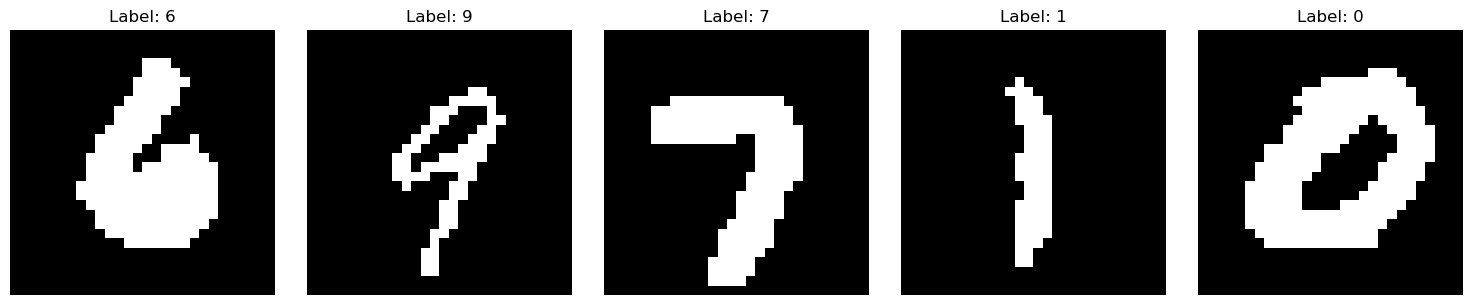

In [44]:
# Create a figure to display the images
plt.figure(figsize=(15, 3))

# Print the first few images in a row
for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(image_binary[i+5,:,:].to('cpu').numpy(), cmap='gray')
#         plt.imshow(image.squeeze()[i+300,:,:].to('cpu').numpy(), cmap='gray')
        plt.title(f"Label: {label[i+5].item()}")
        plt.axis('off')
plt.tight_layout()
plt.show()

In [45]:
data = image_binary.reshape(-1,784).t()
data.shape

torch.Size([784, 2000])

In [46]:
structure = [784,588,392,196,98,49,20,1]
n_dz = torch.tensor(structure)
n_layer = len(n_dz)
n_d = n_dz[0]
n_data = data.shape[1]

In [47]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_I_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Gen_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Gen_I_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Phi_Loss_Layer_5',
 'Phi_Loss_Layer_6',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Theta_Loss_Layer_5',
 'Theta_Loss_Layer_6',
 'Recog_H_Layer_1',
 'Recog_H_Layer_2',
 'Recog_H_Layer_3',
 'Recog_H_Layer_4',
 'Recog_H_Layer_5',
 'Recog_H_Layer_6',
 'Recog_I_Layer_1',
 'Recog_I_Layer_2',
 'Recog_I_Layer_3',
 'Recog_I_Layer_4',
 'Recog_I_Layer_5',
 'Recog_I_Layer_6',
 'Gen_H_Layer_0',
 'Gen_H_Layer_1',
 'Gen_H_Layer_2',
 'Gen_H_Layer_3',
 'Gen_H_Layer_4',
 'Gen_H_Layer_5',
 'Gen_H_Layer_6',
 'Gen_I_Layer_1',
 'Gen_I_Layer_2',
 'Gen_I_Layer_3',
 'Gen_I_Layer_4',
 'Gen_I_Layer_5',
 'Gen_I_Layer_6']

In [48]:
len(col_list)

38

In [54]:
Analytic_MNISTsm_ws_online = pd.DataFrame(columns=col_list)
Analytic_MNISTsm_ws_online

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,...,Gen_H_Layer_3,Gen_H_Layer_4,Gen_H_Layer_5,Gen_H_Layer_6,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6


In [55]:
Phi,Theta = para_init(n_dz,dev)

### 1. Train with Wake-Sleep

In [51]:
para = np.load('Parameters_MNISTsm_ws_online.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

D:\Program\anaconda3\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [108]:
Analytic_MNISTsm_ws_online = pd.read_csv('Analytic_MNISTsm_ws_online.csv', sep=",")
Analytic_MNISTsm_ws_online

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Phi_Loss_Layer_8,Phi_Loss_Layer_9,Theta_Loss_Layer_0,...,Gen_H_Layer_9,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7,Gen_I_Layer_8,Gen_I_Layer_9
0,0.006165,3.806109e-04,9.534236e-04,1.163364e-03,3.419178e-03,2.117835e-02,5.569154e-02,0.338580,0.374167,2.272480,...,2.177533,0.000005,0.000463,0.000161,-0.000006,0.000241,-0.000114,0.000080,4.859358e-03,0.189087
1,0.002588,8.179012e-05,1.195845e-04,7.241417e-05,2.010567e-04,6.220784e-04,2.637426e-03,0.016496,0.065165,1.715039,...,0.693665,0.002229,0.000547,0.000132,0.000444,-0.000286,0.000154,0.000010,9.748340e-04,0.016601
2,0.002347,3.643706e-05,7.453193e-05,8.517465e-05,1.457130e-04,9.193185e-04,1.776048e-03,0.009572,0.131854,1.650599,...,0.921604,0.002429,0.000284,-0.000456,0.000303,0.000203,0.000389,0.000001,2.465397e-05,0.009481
3,0.001961,5.524217e-05,2.667295e-05,4.097650e-05,1.345142e-04,1.380146e-03,5.741500e-04,0.005275,0.032433,1.559167,...,0.206812,0.005000,0.000220,0.001063,-0.000377,0.000790,0.000056,-0.000048,2.533197e-06,0.002177
4,0.001816,2.835854e-05,3.581530e-05,2.804735e-05,1.712238e-04,5.937814e-04,4.351044e-04,0.002448,0.018868,1.482755,...,0.164624,0.001996,0.000624,-0.001060,0.000766,0.000436,0.000100,-0.000005,-7.476658e-06,0.000809
5,0.001504,1.303523e-05,1.541946e-05,7.567057e-05,1.720451e-04,7.099034e-04,2.658292e-04,0.003631,0.019530,1.512539,...,0.189523,0.002375,-0.000870,-0.000902,-0.000435,-0.000272,0.000365,-0.000018,3.755651e-05,0.001265
6,0.001532,1.433956e-05,1.002240e-05,4.135472e-05,2.789324e-05,2.345556e-04,8.828519e-04,0.002668,0.017458,1.428858,...,0.134308,0.012452,-0.000739,-0.000721,-0.000546,0.000428,0.000049,-0.000007,8.478761e-06,0.000616
7,0.001395,4.437515e-06,3.594021e-05,1.817534e-05,6.197717e-05,3.119569e-04,5.804766e-04,0.003030,0.009812,1.474162,...,0.130696,0.019402,-0.001260,-0.000781,-0.000523,0.000584,0.000452,-0.000012,-1.918524e-06,0.000542
8,0.001026,9.433415e-06,5.390342e-06,2.531065e-05,5.161396e-05,1.667210e-04,4.080718e-04,0.000600,0.019278,1.498870,...,0.077292,0.008494,-0.000942,-0.000665,-0.000673,0.000693,-0.000348,-0.000009,-2.188608e-06,0.000177
9,0.000972,1.348348e-05,1.046503e-05,2.772197e-07,6.032397e-05,2.912665e-04,2.105160e-04,0.001085,0.002139,1.567860,...,0.033512,0.015951,-0.001249,-0.000851,-0.000674,-0.000507,-0.000453,0.000102,2.798997e-05,0.000121


In [63]:
batch_size = 1
lr = 0.1
epoch = 5
gen_batch_size = 60000
n_data

2000

In [64]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    for i in range(n_data):
        Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,perturb=False)
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
    if e%5 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/n_data).to('cpu').numpy())
        stat = stat + list((Loss_S/n_data).to('cpu').numpy())
        
        H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,30),dev) # batch_size = 60000
        H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
        stat = stat + list(H_Y_wake.numpy()) + list(I_wake.numpy()) + list(H_Y_sleep.numpy()) + list(I_sleep.numpy())
        Analytic_MNISTsm_ws_online.loc[len(Analytic_MNISTsm_ws_online)] = stat

Loss_wake: tensor([0.0000e+00, 9.9073e-04, 3.4789e-05, 1.9991e-04, 9.5299e-04, 2.1664e-04,
        3.2405e-02])     Loss_sleep: tensor([1.8328e+00, 4.4650e-02, 1.9943e-05, 7.6335e-05, 7.2668e-04, 5.3731e-04,
        2.9965e-02])
Loss_wake: tensor([0.0000e+00, 1.0677e-03, 1.6786e-05, 3.9588e-04, 1.7237e-04, 6.3126e-04,
        5.2962e-02])     Loss_sleep: tensor([1.8034e+00, 4.9649e-02, 1.8468e-05, 2.1238e-04, 1.0840e-04, 8.1094e-04,
        4.1011e-02])
Loss_wake: tensor([0.0000, 0.0010, 0.0001, 0.0002, 0.0003, 0.0005, 0.0422])     Loss_sleep: tensor([1.7858e+00, 4.7026e-02, 6.9805e-05, 1.1744e-04, 1.1660e-04, 7.2535e-04,
        3.6092e-02])
Loss_wake: tensor([0.0000e+00, 6.2684e-04, 3.4356e-07, 1.4811e-04, 3.7470e-04, 1.3265e-04,
        2.9914e-02])     Loss_sleep: tensor([1.8428e+00, 3.8292e-02, 2.2526e-06, 9.4342e-05, 1.2396e-04, 2.7756e-05,
        2.2904e-02])
Loss_wake: tensor([0.0000e+00, 6.5498e-04, 3.5190e-07, 2.4767e-04, 4.1630e-04, 2.3853e-04,
        1.6442e-02])     Loss

In [65]:
Analytic_MNISTsm_ws_online

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,...,Gen_H_Layer_3,Gen_H_Layer_4,Gen_H_Layer_5,Gen_H_Layer_6,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6
0,0.030965,7.694476e-03,0.031901,0.072212,0.272817,0.634945,1.887373,0.356480,0.004605,0.014689,...,0.644833,1.104660,4.190169,8.451181,0.017457,-0.000179,0.000142,0.000170,0.006241,0.320108
1,0.005905,7.342348e-04,0.003390,0.002480,0.014972,0.264986,1.726449,0.132483,0.000419,0.001720,...,0.340028,0.136762,0.355136,4.241238,0.104072,-0.000058,0.000030,0.000003,0.000067,0.017606
2,0.002988,2.155407e-04,0.001056,0.001034,0.004061,0.145896,1.714996,0.083942,0.000145,0.000579,...,0.147291,0.192463,0.094421,2.172370,0.085711,0.000026,-0.000038,0.000026,0.000028,0.002564
3,0.003277,2.318992e-04,0.000299,0.001647,0.004559,0.138588,1.645111,0.107794,0.000116,0.000161,...,0.041416,0.090230,0.118015,1.977507,0.127977,0.000048,0.000014,-0.000031,0.000018,0.003218
4,0.003426,3.676852e-04,0.000741,0.000821,0.000809,0.074634,1.645360,0.115299,0.000212,0.000391,...,0.106797,0.063918,0.034070,1.157336,0.113143,0.000137,0.000066,0.000029,0.000002,0.000619
5,0.002811,1.233716e-04,0.000487,0.000688,0.003214,0.040795,1.688951,0.092209,0.000087,0.000337,...,0.062997,0.033136,0.047361,0.713661,0.110517,0.000079,0.000331,0.000030,0.000015,0.000317
6,0.002306,1.977175e-04,0.000166,0.000494,0.003161,0.046408,1.758477,0.077710,0.000105,0.000097,...,0.025194,0.030236,0.131059,0.810429,0.073318,0.000048,0.000371,0.000002,0.000024,0.001360
7,0.001912,3.635144e-05,0.000369,0.000300,0.000726,0.046999,1.787085,0.076155,0.000019,0.000190,...,0.024643,0.030865,0.029284,0.840343,0.177782,-0.000052,0.000100,0.000044,-0.000012,0.000175
8,0.001959,1.264172e-04,0.000480,0.000262,0.000976,0.078573,1.812275,0.070631,0.000061,0.000279,...,0.024514,0.018657,0.036052,1.297304,0.144879,0.000208,0.000464,0.000023,0.000003,0.000419
9,0.001728,2.296999e-04,0.000332,0.000006,0.000694,0.061446,1.861841,0.057476,0.000130,0.000190,...,0.030047,0.016895,0.042684,0.800426,0.140146,-0.000064,0.000170,0.000066,0.000009,0.000232


In [66]:
gen_batch_size = 10
gen = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"]
gen.shape

torch.Size([784, 10])

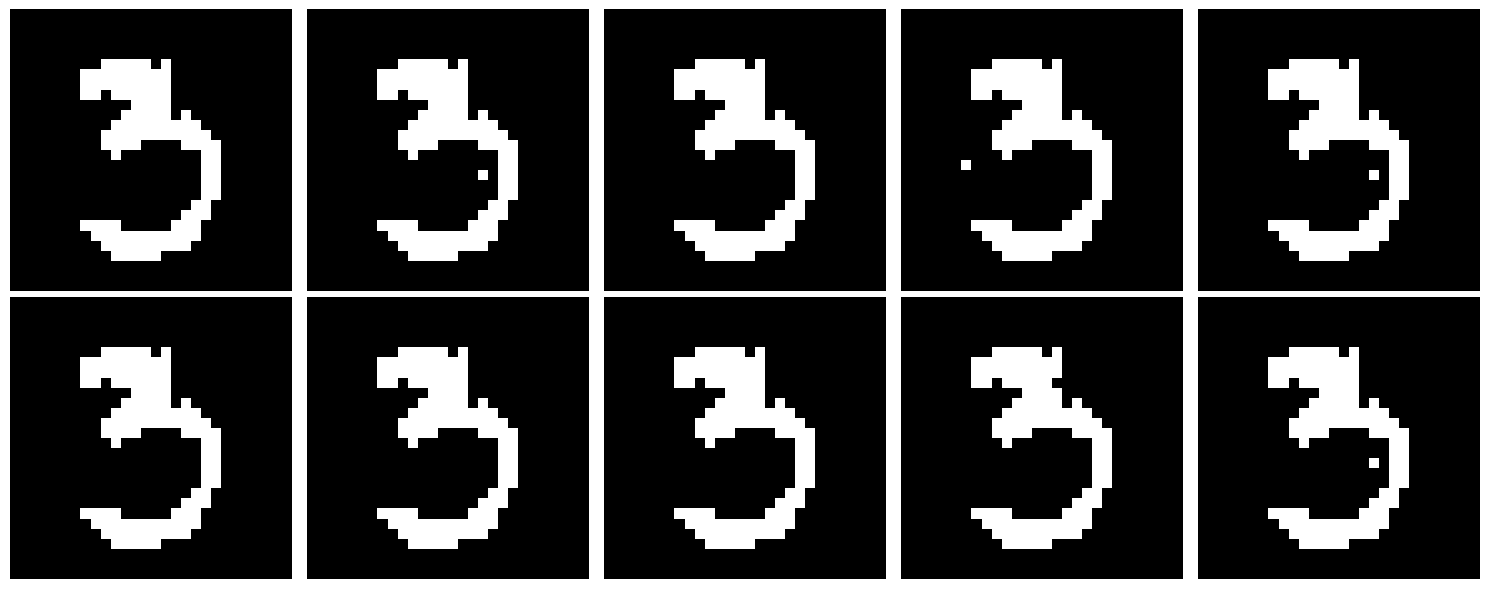

In [67]:
# Create a figure to display the images
fig, axs = plt.subplots(2, 5,figsize=(15, 6))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(gen[:,i*5+j].reshape(28,28).to('cpu').numpy(), cmap='gray')
        axs[i,j].axis('off')
plt.tight_layout()
plt.show()

In [70]:
Analytic_MNISTsm_ws_online.to_csv('Analytic_MNISTsm_ws_online.csv', index = False)

In [71]:
parameters = {'Phi': Phi, 'Theta': Theta}
np.save('Parameters_MNISTsm_ws_online',parameters)

### 2. Train with Mutual Information Maximization (MNIST 0)

In [72]:
para = np.load('Parameters_MNISTsm_ws_online.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

D:\Program\anaconda3\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [73]:
Analytic_MNISTsm_ws_online_MI = pd.read_csv('Analytic_MNISTsm_ws_online.csv', sep=",")
Analytic_MNISTsm_ws_online_MI

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,...,Gen_H_Layer_3,Gen_H_Layer_4,Gen_H_Layer_5,Gen_H_Layer_6,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6
0,0.030965,7.694476e-03,0.031901,0.072212,0.272817,0.634945,1.887373,0.356480,0.004605,0.014689,...,0.644833,1.104660,4.190169,8.451181,0.017457,-0.000179,0.000142,0.000170,0.006241,0.320108
1,0.005905,7.342348e-04,0.003390,0.002480,0.014972,0.264986,1.726449,0.132483,0.000419,0.001720,...,0.340029,0.136762,0.355136,4.241238,0.104072,-0.000058,0.000030,0.000003,0.000067,0.017606
2,0.002988,2.155407e-04,0.001056,0.001034,0.004061,0.145896,1.714997,0.083942,0.000145,0.000579,...,0.147291,0.192463,0.094421,2.172370,0.085711,0.000026,-0.000038,0.000026,0.000028,0.002564
3,0.003277,2.318992e-04,0.000299,0.001647,0.004559,0.138588,1.645111,0.107794,0.000116,0.000161,...,0.041416,0.090230,0.118015,1.977507,0.127977,0.000048,0.000014,-0.000031,0.000018,0.003218
4,0.003426,3.676852e-04,0.000741,0.000821,0.000809,0.074634,1.645360,0.115299,0.000212,0.000391,...,0.106797,0.063918,0.034070,1.157336,0.113143,0.000137,0.000066,0.000029,0.000002,0.000619
5,0.002811,1.233716e-04,0.000487,0.000688,0.003214,0.040795,1.688951,0.092209,0.000087,0.000337,...,0.062997,0.033136,0.047361,0.713661,0.110517,0.000079,0.000331,0.000030,0.000015,0.000317
6,0.002306,1.977175e-04,0.000166,0.000494,0.003161,0.046408,1.758477,0.077710,0.000105,0.000097,...,0.025194,0.030236,0.131059,0.810429,0.073318,0.000048,0.000371,0.000002,0.000024,0.001360
7,0.001912,3.635144e-05,0.000369,0.000300,0.000726,0.046999,1.787085,0.076154,0.000019,0.000190,...,0.024643,0.030865,0.029284,0.840343,0.177782,-0.000052,0.000100,0.000044,-0.000012,0.000175
8,0.001959,1.264172e-04,0.000480,0.000262,0.000976,0.078573,1.812275,0.070631,0.000061,0.000279,...,0.024514,0.018657,0.036052,1.297304,0.144879,0.000208,0.000464,0.000023,0.000003,0.000419
9,0.001728,2.296999e-04,0.000332,0.000006,0.000694,0.061446,1.861841,0.057476,0.000130,0.000190,...,0.030047,0.016895,0.042684,0.800426,0.140147,-0.000064,0.000170,0.000066,0.000009,0.000232


In [100]:
batch_size = 1
lr = 0.1
epoch = 10
gen_batch_size = 60000
n_data

2000

In [131]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    T,Epsilon,Eta = initialize_MI(data.repeat(1,10),Phi,lr,dev)
    for i in range(n_data):
        if i%5 == 0:
            Theta, Loss_sleep, T = wake_phase_MI(Phi,Theta,data[:,index[i]:index[i]+1],lr,T,Epsilon,Eta,dev)
        else:
            Theta, Loss_sleep, T = wake_phase_update(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,T,Eta)
        # Sleep Phase
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
    if e%5 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/n_data).to('cpu').numpy())
        stat = stat + list((Loss_S/n_data).to('cpu').numpy())
        
        H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,30),dev) # batch_size = 60000
        H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
        stat = stat + list(H_Y_wake.numpy()) + list(I_wake.numpy()) + list(H_Y_sleep.numpy()) + list(I_sleep.numpy())
        Analytic_MNISTsm_ws_online_MI.loc[len(Analytic_MNISTsm_ws_online_MI)] = stat

Loss_wake: tensor([0.0000, 0.3808, 0.1384, 0.4494, 0.7940, 0.5760, 0.4653])     Loss_sleep: tensor([0.4167, 1.0732, 0.1472, 0.1648, 0.3155, 0.4567, 0.6608])
Loss_wake: tensor([0.0000, 0.3916, 0.1380, 0.4279, 0.8224, 0.5860, 0.4701])     Loss_sleep: tensor([0.4158, 1.1144, 0.1499, 0.1555, 0.3213, 0.4599, 0.6605])
Loss_wake: tensor([0.0000, 0.3960, 0.1235, 0.3975, 0.8587, 0.5541, 0.4739])     Loss_sleep: tensor([0.4135, 1.1277, 0.1434, 0.1448, 0.3277, 0.4544, 0.6577])
Loss_wake: tensor([0.0000, 0.4032, 0.1190, 0.4416, 0.7993, 0.5491, 0.4770])     Loss_sleep: tensor([0.4251, 1.1359, 0.1380, 0.1658, 0.3154, 0.4422, 0.6548])
Loss_wake: tensor([0.0000, 0.4100, 0.1209, 0.3974, 0.8027, 0.5661, 0.4696])     Loss_sleep: tensor([0.4185, 1.1650, 0.1386, 0.1534, 0.3236, 0.4499, 0.6604])
Loss_wake: tensor([0.0000, 0.3973, 0.1292, 0.4124, 0.7654, 0.5906, 0.4665])     Loss_sleep: tensor([0.4045, 1.1448, 0.1439, 0.1591, 0.3077, 0.4554, 0.6508])
Loss_wake: tensor([0.0000, 0.4008, 0.1148, 0.4439, 0.7933,

In [135]:
Analytic_MNISTsm_ws_online_MI

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,...,Gen_H_Layer_3,Gen_H_Layer_4,Gen_H_Layer_5,Gen_H_Layer_6,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6
0,0.030965,7.694476e-03,0.031901,0.072212,0.272817,0.634945,1.887373,0.356480,0.004605,0.014689,...,0.644833,1.104660,4.190169,8.451181,0.017457,-0.000179,0.000142,0.000170,0.006241,0.320108
1,0.005905,7.342348e-04,0.003390,0.002480,0.014972,0.264986,1.726449,0.132483,0.000419,0.001720,...,0.340029,0.136762,0.355136,4.241238,0.104072,-0.000058,0.000030,0.000003,0.000067,0.017606
2,0.002988,2.155407e-04,0.001056,0.001034,0.004061,0.145896,1.714997,0.083942,0.000145,0.000579,...,0.147291,0.192463,0.094421,2.172370,0.085711,0.000026,-0.000038,0.000026,0.000028,0.002564
3,0.003277,2.318992e-04,0.000299,0.001647,0.004559,0.138588,1.645111,0.107794,0.000116,0.000161,...,0.041416,0.090230,0.118015,1.977507,0.127977,0.000048,0.000014,-0.000031,0.000018,0.003218
4,0.003426,3.676852e-04,0.000741,0.000821,0.000809,0.074634,1.645360,0.115299,0.000212,0.000391,...,0.106797,0.063918,0.034070,1.157336,0.113143,0.000137,0.000066,0.000029,0.000002,0.000619
5,0.002811,1.233716e-04,0.000487,0.000688,0.003214,0.040795,1.688951,0.092209,0.000087,0.000337,...,0.062997,0.033136,0.047361,0.713661,0.110517,0.000079,0.000331,0.000030,0.000015,0.000317
6,0.002306,1.977175e-04,0.000166,0.000494,0.003161,0.046408,1.758477,0.077710,0.000105,0.000097,...,0.025194,0.030236,0.131059,0.810429,0.073318,0.000048,0.000371,0.000002,0.000024,0.001360
7,0.001912,3.635144e-05,0.000369,0.000300,0.000726,0.046999,1.787085,0.076154,0.000019,0.000190,...,0.024643,0.030865,0.029284,0.840343,0.177782,-0.000052,0.000100,0.000044,-0.000012,0.000175
8,0.001959,1.264172e-04,0.000480,0.000262,0.000976,0.078573,1.812275,0.070631,0.000061,0.000279,...,0.024514,0.018657,0.036052,1.297304,0.144879,0.000208,0.000464,0.000023,0.000003,0.000419
9,0.001728,2.296999e-04,0.000332,0.000006,0.000694,0.061446,1.861841,0.057476,0.000130,0.000190,...,0.030047,0.016895,0.042684,0.800426,0.140147,-0.000064,0.000170,0.000066,0.000009,0.000232


In [136]:
gen_batch_size = 10
gen = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"]
gen.shape

torch.Size([784, 10])

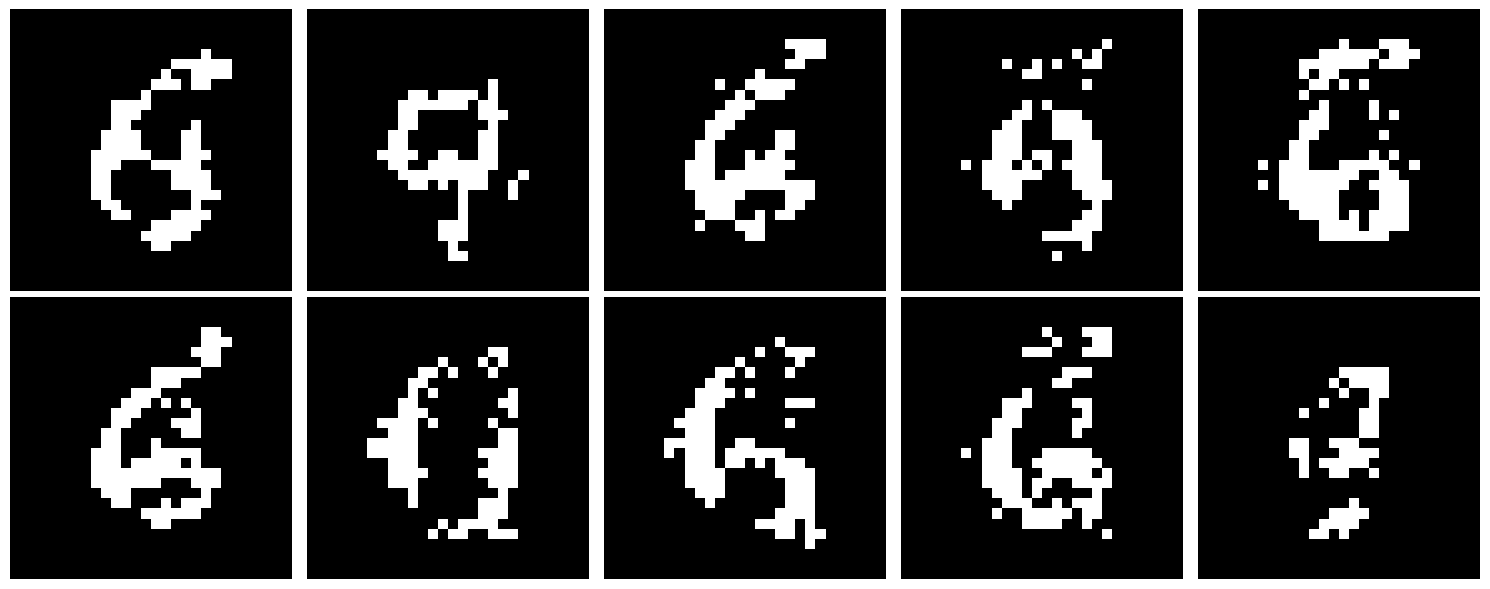

In [137]:
# Create a figure to display the images
fig, axs = plt.subplots(2, 5,figsize=(15, 6))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(gen[:,i*5+j].reshape(28,28).to('cpu').numpy(), cmap='gray')
        axs[i,j].axis('off')
plt.tight_layout()
plt.show()

In [117]:
Analytic_MNISTsm_ws_online_MI.to_csv('Analytic_MNISTsm_ws_online_MI.csv', index = False)

In [118]:
parameters = {'Phi': Phi, 'Theta': Theta}
np.save('Parameters_MNISTsm_ws_online_MI_10',parameters)

### 3. Train with Perturbation (MNIST 0)

In [54]:
para = np.load('Parameters_MNIST0_ws_online.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

D:\Program\anaconda3\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [55]:
Analytic_MNIST0_ws_online_perturb = pd.read_csv('Analytic_MNIST0_ws_online.csv', sep=",")
Analytic_MNIST0_ws_online_perturb

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,...,Gen_H_Layer_3,Gen_H_Layer_4,Gen_H_Layer_5,Gen_H_Layer_6,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6
0,0.006820,4.907783e-03,1.721537e-02,0.056744,0.178583,0.380872,2.138885,0.077085,0.002586,0.007401,...,0.419383,1.456281,1.728554,4.185556,0.008784,-4.321337e-07,0.000124,0.000280,0.009011,0.092591
1,0.002977,4.018032e-04,6.844296e-04,0.003640,0.002020,0.057662,1.426926,0.106183,0.000239,0.000341,...,0.073449,0.351631,0.052584,1.064860,0.097263,2.971701e-04,-0.000118,0.000021,0.000042,0.000607
2,0.003179,2.284715e-04,4.994693e-04,0.001391,0.002899,0.048388,1.243643,0.133524,0.000126,0.000336,...,0.040614,0.290375,0.044183,0.894908,0.141441,1.223758e-05,0.000022,0.000054,0.000043,0.000485
3,0.002713,1.052832e-04,7.850805e-04,0.000407,0.004979,0.034153,1.174655,0.129329,0.000086,0.000422,...,0.031922,0.027495,0.101490,0.472199,0.224436,2.523549e-04,0.000102,-0.000024,-0.000019,0.000541
4,0.001463,1.527827e-04,3.973937e-04,0.001269,0.004752,0.019318,1.460983,0.067599,0.000102,0.000219,...,0.041650,0.072600,0.075128,0.350269,0.123636,3.814399e-04,-0.000193,-0.000005,0.000024,0.000309
5,0.001402,7.701050e-05,2.972847e-04,0.000825,0.000288,0.057900,1.304661,0.074673,0.000044,0.000189,...,0.052977,0.080384,0.024888,1.135861,0.161546,2.593920e-04,0.000471,0.000092,-0.000012,0.000189
6,0.001607,5.854173e-05,1.976120e-04,0.000406,0.004570,0.033574,1.252876,0.083224,0.000029,0.000120,...,0.059600,0.031699,0.125227,0.353533,0.249436,-6.129034e-05,0.000126,0.000107,-0.000032,0.000574
7,0.000857,8.287619e-05,4.118372e-04,0.000243,0.002067,0.031497,1.475861,0.053056,0.000050,0.000219,...,0.015518,0.034384,0.056946,0.640674,0.076010,-2.573617e-04,0.000196,0.000016,-0.000011,0.000771
8,0.000864,5.877717e-05,5.079072e-04,0.000971,0.005613,0.010785,1.511078,0.048000,0.000052,0.000241,...,0.663770,0.034502,0.069670,0.271787,0.173310,-1.311218e-04,0.000342,0.000129,0.000040,0.000195
9,0.000581,4.741145e-05,3.254844e-04,0.000256,0.001008,0.014033,1.654133,0.034371,0.000045,0.000181,...,0.050120,0.020180,0.044235,0.364699,0.169333,-2.944060e-04,-0.000425,-0.000011,0.000023,0.000133


In [56]:
batch_size = 1
lr = 0.1
epoch = 10
gen_batch_size = 60000
n_data

5923

In [ ]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    T,Epsilon,Eta = initialize_MI(data.repeat(1,10),Phi,lr,dev)
    for i in range(n_data):
        if i%10 == 0:
            Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,perturb=True)
        else:
            Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,perturb=False)
        # Sleep Phase
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
    if e%5 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/n_data).to('cpu').numpy())
        stat = stat + list((Loss_S/n_data).to('cpu').numpy())
        
        H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,10),dev) # batch_size = 60000
        H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
        stat = stat + list(H_Y_wake.numpy()) + list(I_wake.numpy()) + list(H_Y_sleep.numpy()) + list(I_sleep.numpy())
        Analytic_MNIST0_ws_online_perturb.loc[len(Analytic_MNIST0_ws_online_perturb)] = stat

In [258]:
Analytic_MNIST0_ws_online_perturb

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Phi_Loss_Layer_8,Phi_Loss_Layer_9,Theta_Loss_Layer_0,...,Gen_H_Layer_9,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7,Gen_I_Layer_8,Gen_I_Layer_9
0,0.006165,0.000381,0.000953,0.001163,0.003419,0.021178,0.055692,0.338580,0.374167,2.272480,...,2.177533,0.000005,0.000463,0.000161,-0.000006,0.000241,-0.000114,0.000080,0.004859,0.189087
1,0.002588,0.000082,0.000120,0.000072,0.000201,0.000622,0.002637,0.016496,0.065165,1.715039,...,0.693665,0.002229,0.000547,0.000132,0.000444,-0.000286,0.000154,0.000010,0.000975,0.016601
2,0.002347,0.000036,0.000075,0.000085,0.000146,0.000919,0.001776,0.009572,0.131854,1.650599,...,0.921604,0.002429,0.000284,-0.000456,0.000303,0.000203,0.000389,0.000001,0.000025,0.009481
3,0.001961,0.000055,0.000027,0.000041,0.000135,0.001380,0.000574,0.005275,0.032433,1.559167,...,0.206812,0.005000,0.000220,0.001063,-0.000377,0.000790,0.000056,-0.000048,0.000003,0.002177
4,0.001816,0.000028,0.000036,0.000028,0.000171,0.000594,0.000435,0.002448,0.018868,1.482755,...,0.164624,0.001996,0.000624,-0.001060,0.000766,0.000436,0.000100,-0.000005,-0.000007,0.000809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.308953,2.453736,2.177555,1.940145,1.708340,1.468242,1.170308,0.878778,0.709621,1.304744,...,6.495252,86.884521,134.830551,111.315552,87.747192,72.340622,58.545502,33.471096,13.056747,1.622656
85,1.308600,2.450397,2.172003,1.931342,1.709533,1.465082,1.182286,0.861419,0.706555,1.308509,...,6.699986,114.880180,162.057037,123.156303,98.604668,80.894997,61.410618,32.456421,12.616108,1.655396
86,1.303963,2.450441,2.177042,1.929302,1.694680,1.471428,1.159695,0.862184,0.719673,1.321469,...,6.751266,118.593552,145.325623,119.564850,96.164131,68.651764,52.103695,29.773041,11.561749,1.731262
87,1.306510,2.453513,2.169631,1.920465,1.711626,1.480637,1.184760,0.872173,0.707517,1.315311,...,6.712749,82.298622,132.966156,102.152252,87.125183,74.854889,57.171337,29.776688,12.220768,1.842836


In [266]:
gen_batch_size = 10
gen = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"]
gen.shape

torch.Size([784, 10])

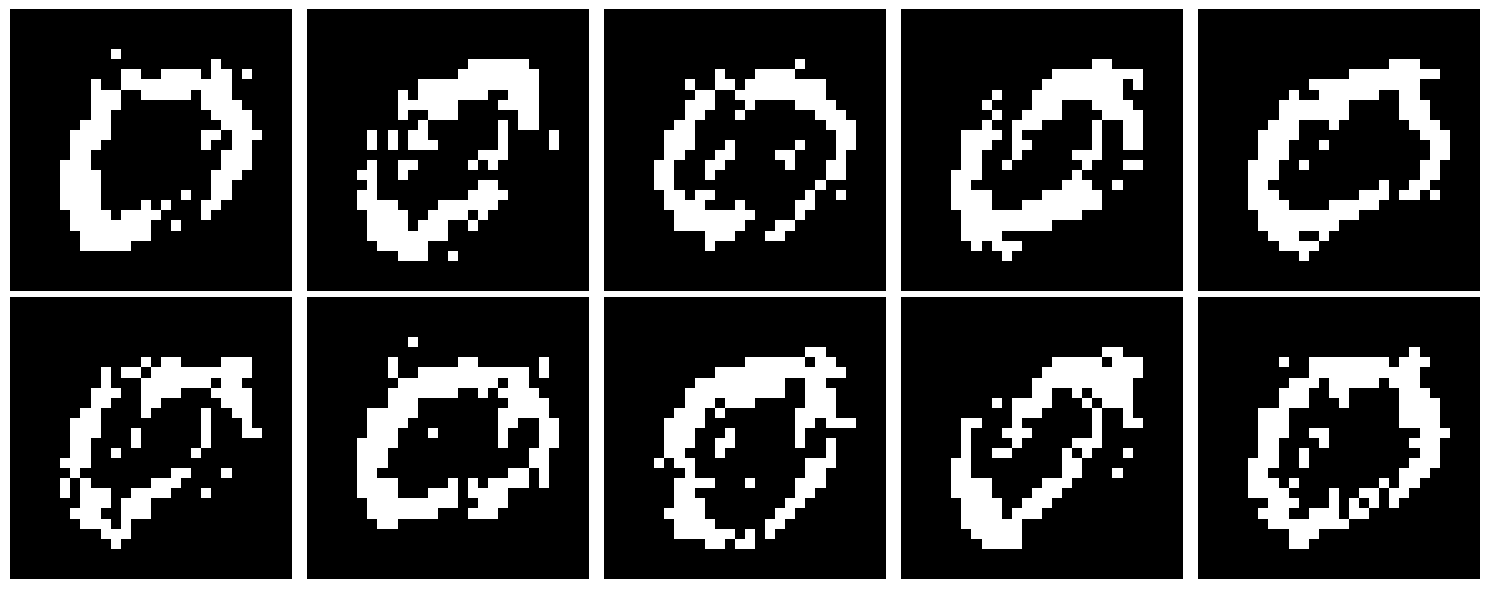

In [267]:
# Create a figure to display the images
fig, axs = plt.subplots(2, 5,figsize=(15, 6))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(gen[:,i*5+j].reshape(28,28).to('cpu').numpy(), cmap='gray')
        axs[i,j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
Analytic_MNIST0_ws_online_perturb.to_csv('Analytic_MNIST0_ws_online_perturb.csv', index = False)

In [ ]:
parameters = {'Phi': Phi, 'Theta': Theta}
np.save('Parameters_MNIST0_ws_online_perturb_10',parameters)

### 4. Train with Batch

In [1]:
# dev = torch.device("cuda") # operate on GPU "cuda" or CPU "cpu"

In [50]:
data = data.to(dev)
data.shape

torch.Size([784, 5923])

In [2]:
# Analytic_MNIST0_batch = pd.read_csv('Analytic_MNIST0_batch.csv', sep=",")
# Analytic_MNIST0_batch

In [3]:
# para = np.load('Parameters_MNIST0_batch.npy',allow_pickle=True).item()
# Phi = para['Phi']
# Theta = para['Theta']

In [54]:
batch_size = n_data
lr = 0.1
epoch = 100000
gen_batch_size = 50000
n_data

5923

In [4]:
# for e in range(epoch):
#     Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev,perturb=False)
#     Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
#     print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
#     if e%500 == 0:
#         stat = []
#         stat = stat + list((Loss_wake[1:]).to('cpu').numpy())
#         stat = stat + list((Loss_sleep).to('cpu').numpy())

#         H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,5),dev) # batch_size = 50000
#         H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
#         stat = stat + list(H_Y_wake.to('cpu').numpy()) + list(I_wake.to('cpu').numpy()) \
#                 + list(H_Y_sleep.to('cpu').numpy()) + list(I_sleep.to('cpu').numpy())
#         Analytic_MNIST0_batch.loc[len(Analytic_MNIST0_batch)] = stat

In [5]:
# Analytic_MNIST0_batch

In [54]:
gen_batch_size = 50
gen = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"].to('cpu')
gen.shape

torch.Size([784, 50])

In [1]:
# # Create a figure to display the images
# fig, axs = plt.subplots(10, 5,figsize=(15, 30))
# for i in range(10):
#     for j in range(5):
#         axs[i,j].imshow(gen[:,i*5+j].reshape(28,28).to('cpu').numpy(), cmap='gray')
#         axs[i,j].axis('off')
# plt.tight_layout()
# plt.show()

In [59]:
Analytic_MNIST0_batch.to_csv('Analytic_MNIST0_batch.csv', index = False)

In [60]:
parameters = {'Phi': Phi, 'Theta': Theta}
np.save('Parameters_MNIST0_batch',parameters)

### Plot Analytic

In [ ]:
Analytic_MNIST0_ws_online = pd.read_csv('Analytic_MNIST0_ws_online.csv', sep=",")
Analytic_MNIST0_ws_online_continue = pd.read_csv('Analytic_MNIST0_ws_online_continue.csv', sep=",")
Analytic_MNIST0_ws_online_MI = pd.read_csv('Analytic_MNIST0_ws_online_MI.csv', sep=",")
Analytic_MNIST0_ws_online_perturb = pd.read_csv('Analytic_MNIST0_ws_online_perturb.csv', sep=",")
Analytic_MNIST0_batch = pd.read_csv('Analytic_MNIST0_batch.csv', sep=",")

In [176]:
Analytic = Analytic_MNIST0_ws_online
Analytic

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Phi_Loss_Layer_8,Phi_Loss_Layer_9,Theta_Loss_Layer_0,...,Gen_H_Layer_9,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7,Gen_I_Layer_8,Gen_I_Layer_9
0,0.006165,0.000381,0.000953,0.001163,0.003419,0.021178,0.055692,0.338580,0.374167,2.272480,...,2.177533,0.000005,0.000463,0.000161,-0.000006,0.000241,-0.000114,0.000080,0.004859,0.189087
1,0.002588,0.000082,0.000120,0.000072,0.000201,0.000622,0.002637,0.016496,0.065165,1.715039,...,0.693665,0.002229,0.000547,0.000132,0.000444,-0.000286,0.000154,0.000010,0.000975,0.016601
2,0.002347,0.000036,0.000075,0.000085,0.000146,0.000919,0.001776,0.009572,0.131854,1.650599,...,0.921604,0.002429,0.000284,-0.000456,0.000303,0.000203,0.000389,0.000001,0.000025,0.009481
3,0.001961,0.000055,0.000027,0.000041,0.000135,0.001380,0.000574,0.005275,0.032433,1.559167,...,0.206812,0.005000,0.000220,0.001063,-0.000377,0.000790,0.000056,-0.000048,0.000003,0.002177
4,0.001816,0.000028,0.000036,0.000028,0.000171,0.000594,0.000435,0.002448,0.018868,1.482755,...,0.164624,0.001996,0.000624,-0.001060,0.000766,0.000436,0.000100,-0.000005,-0.000007,0.000809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.231610,0.036640,0.198916,0.359529,0.197091,0.473811,0.592788,0.657530,0.390190,0.737726,...,5.857586,78.036400,27.614044,2.272282,6.734578,16.865486,10.669596,18.538063,16.194574,4.623642
86,0.170599,0.022501,0.096648,0.476338,0.282642,0.426655,0.635146,0.694190,0.332656,0.772204,...,5.107462,10.999656,2.058711,0.209328,2.791451,18.442322,18.125351,17.015297,16.185053,4.504505
87,0.094639,0.018510,0.025628,0.172468,0.335901,0.434816,0.650482,0.708687,0.349953,0.766939,...,5.855279,1.915243,0.105260,0.015261,0.225530,7.384381,15.753830,17.742390,16.217325,4.457844
88,0.109833,0.020314,0.046945,0.199332,0.177876,0.458220,0.690881,0.666898,0.330617,0.743333,...,5.421564,5.842194,0.438285,0.038213,0.180420,4.339638,7.359932,15.811102,16.750084,4.372553


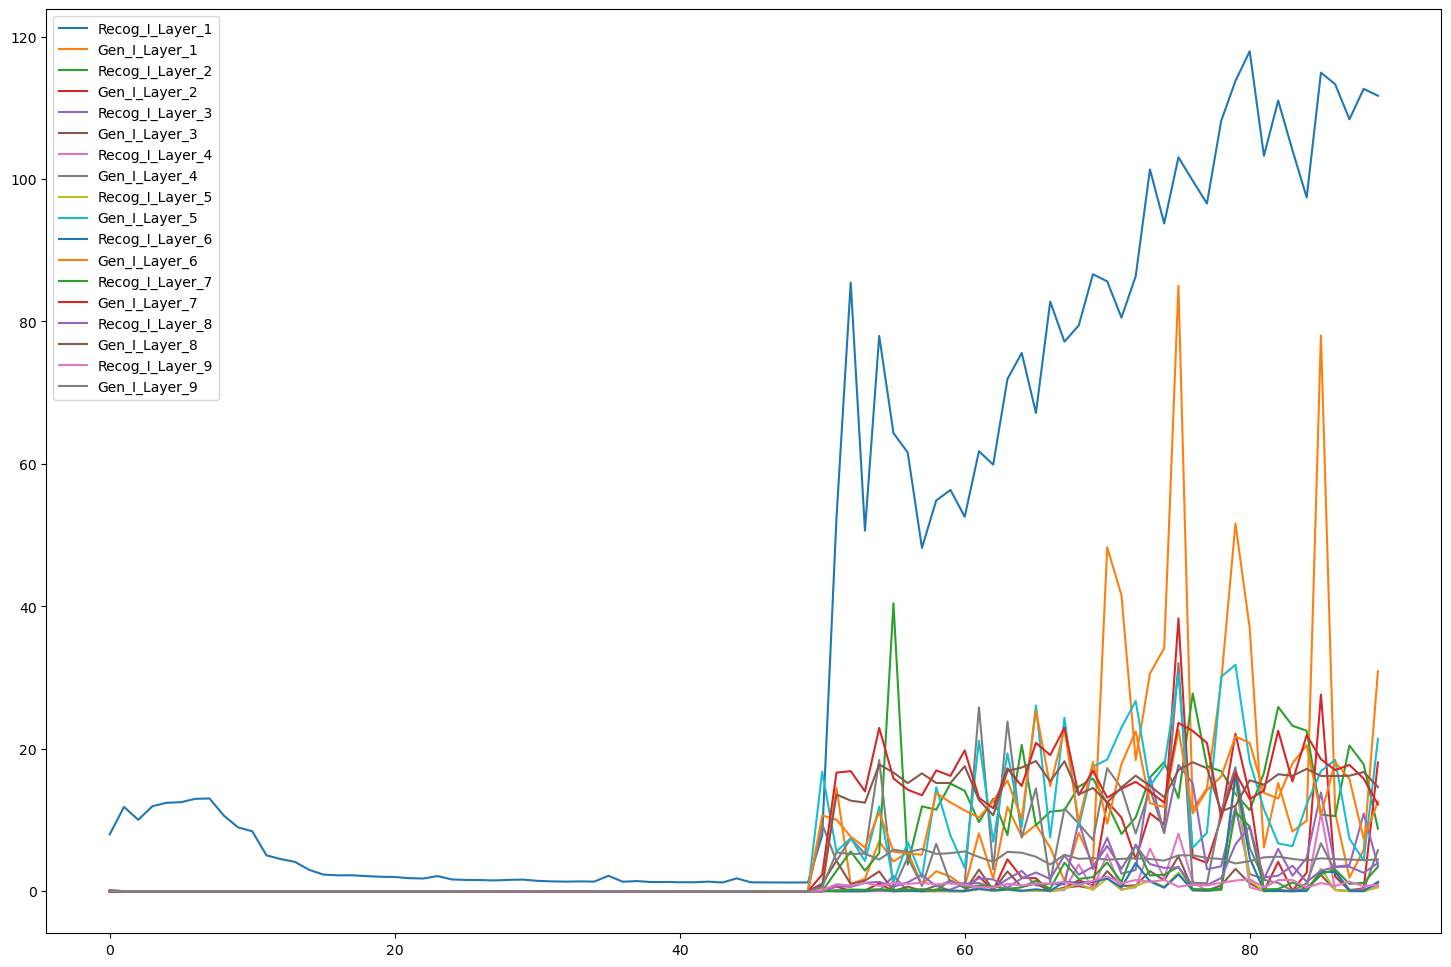

In [177]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_I_Layer_'+str(i)]),label = 'Recog_I_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

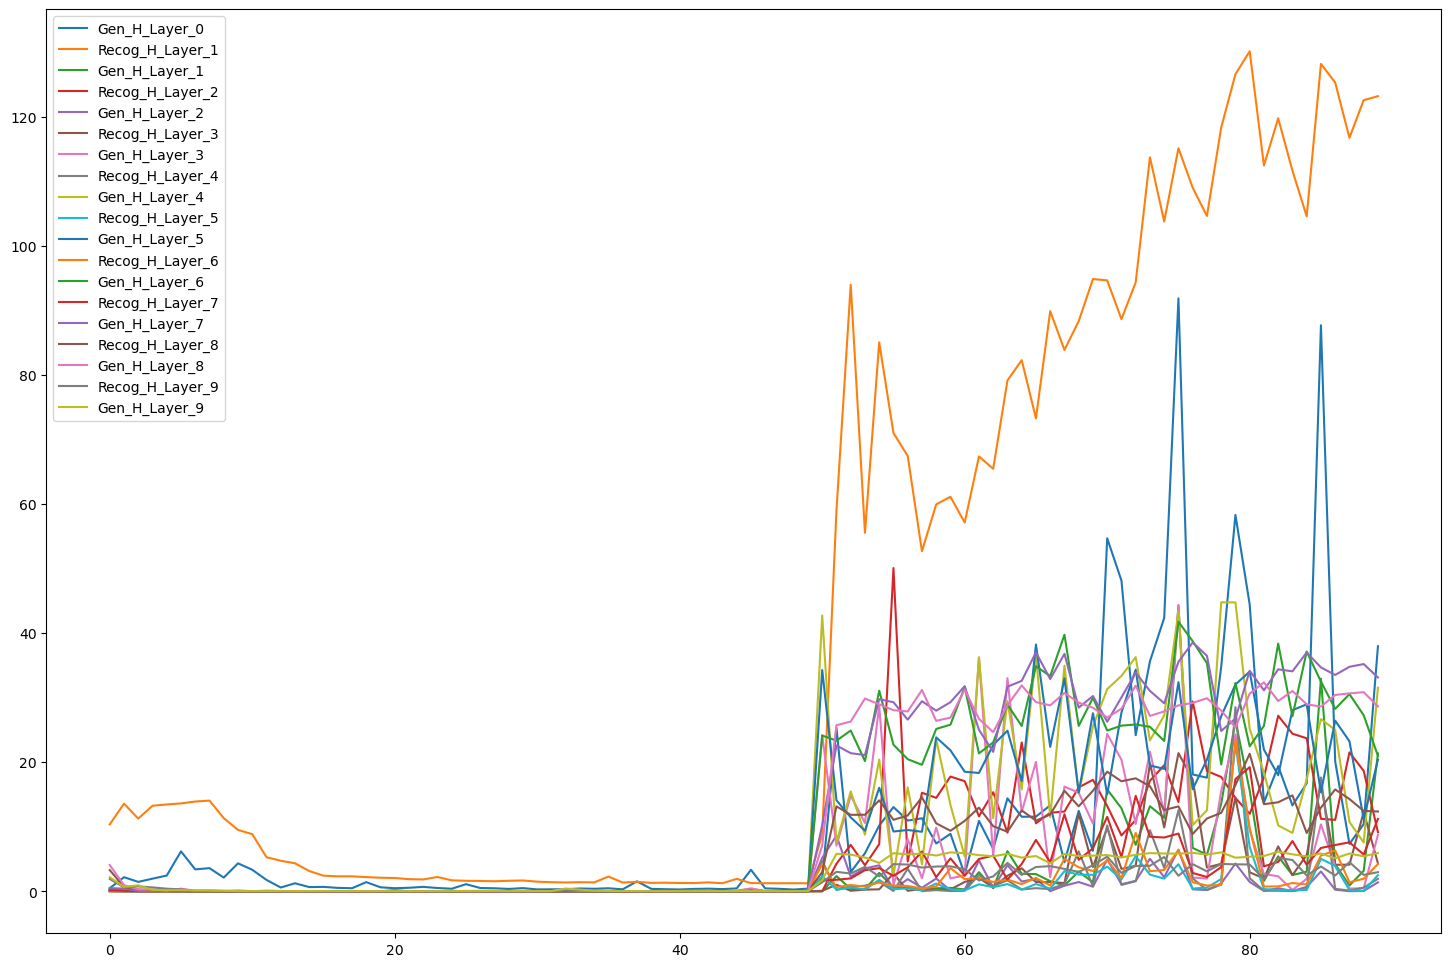

In [178]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

In [179]:
n_dz * np.log(2)

tensor([543.4274, 485.2030, 415.8883, 346.5736, 277.2589, 207.9442, 138.6294,
         69.3147,  34.6574,   6.9315,   0.6931])

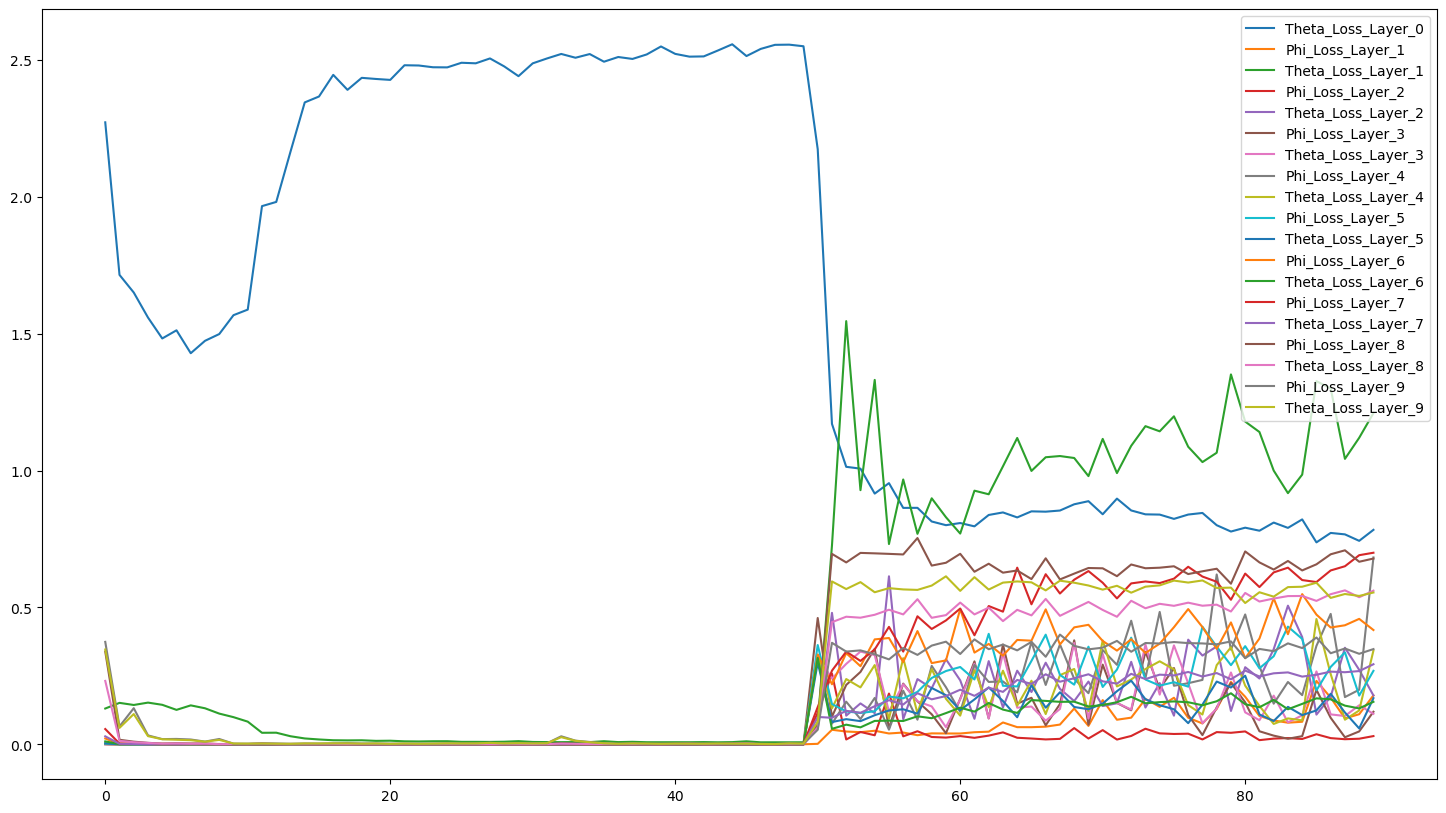

In [180]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()

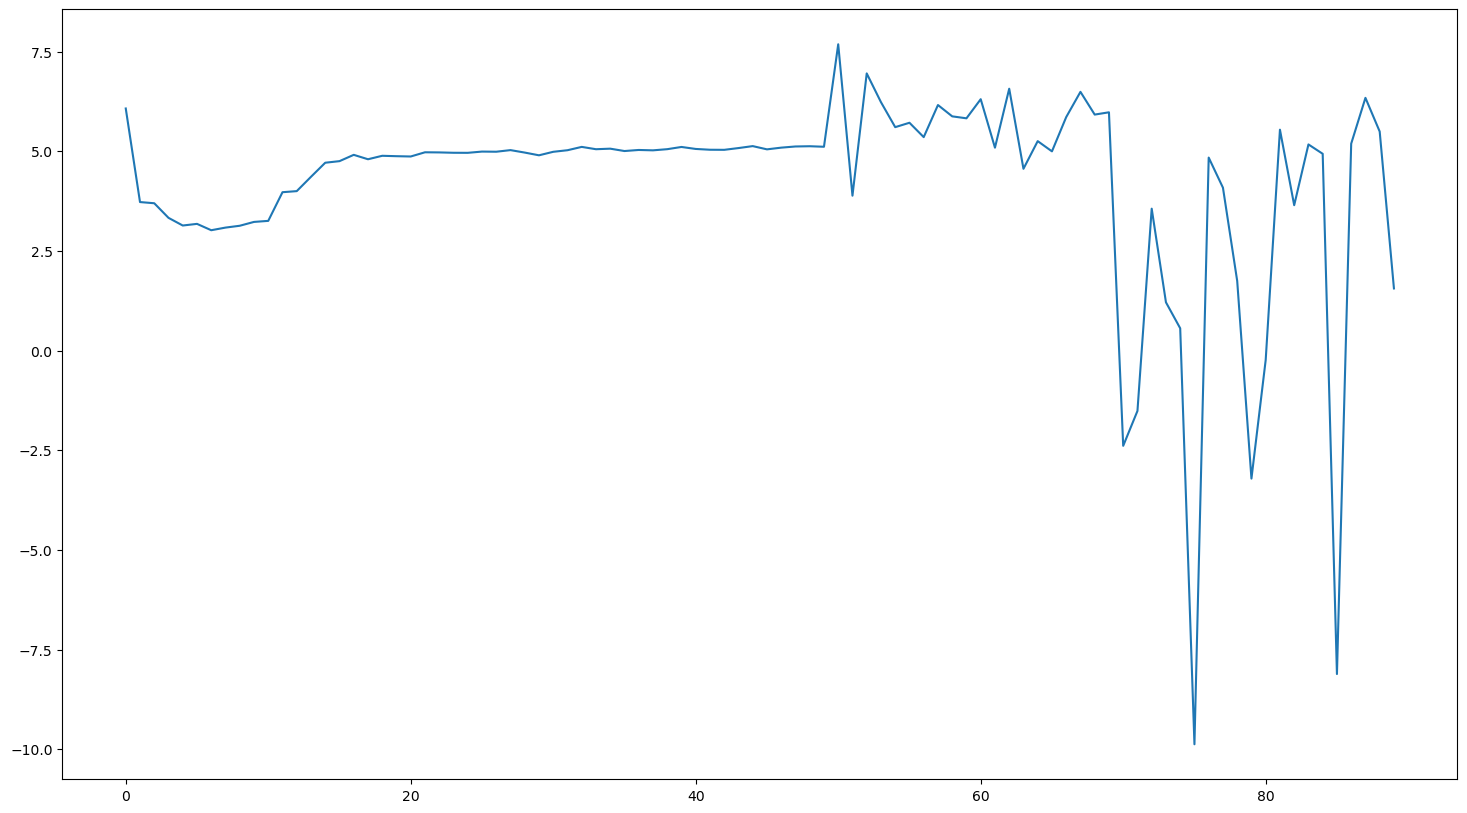

In [181]:
# normalized loss
Loss = 2*(np.array(Analytic['Theta_Loss_Layer_'+str(0)])-(np.array(Analytic['Gen_I_Layer_1'])/structure[i]))
for i in range(1,n_layer-2):
    Loss += np.array(Analytic['Phi_Loss_Layer_'+str(i)]) + np.array(Analytic['Theta_Loss_Layer_'+str(i)]) - \
    (np.array(Analytic['Gen_I_Layer_'+str(i+1)])+np.array(Analytic['Recog_I_Layer_'+str(i)]))/structure[i]
Loss += np.array(Analytic['Phi_Loss_Layer_'+str(n_layer-2)]) + np.array(Analytic['Theta_Loss_Layer_'+str(n_layer-2)]) - \
        np.array(Analytic['Recog_I_Layer_'+str(n_layer-2)])/structure[n_layer-2]
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(Loss)
plt.show()

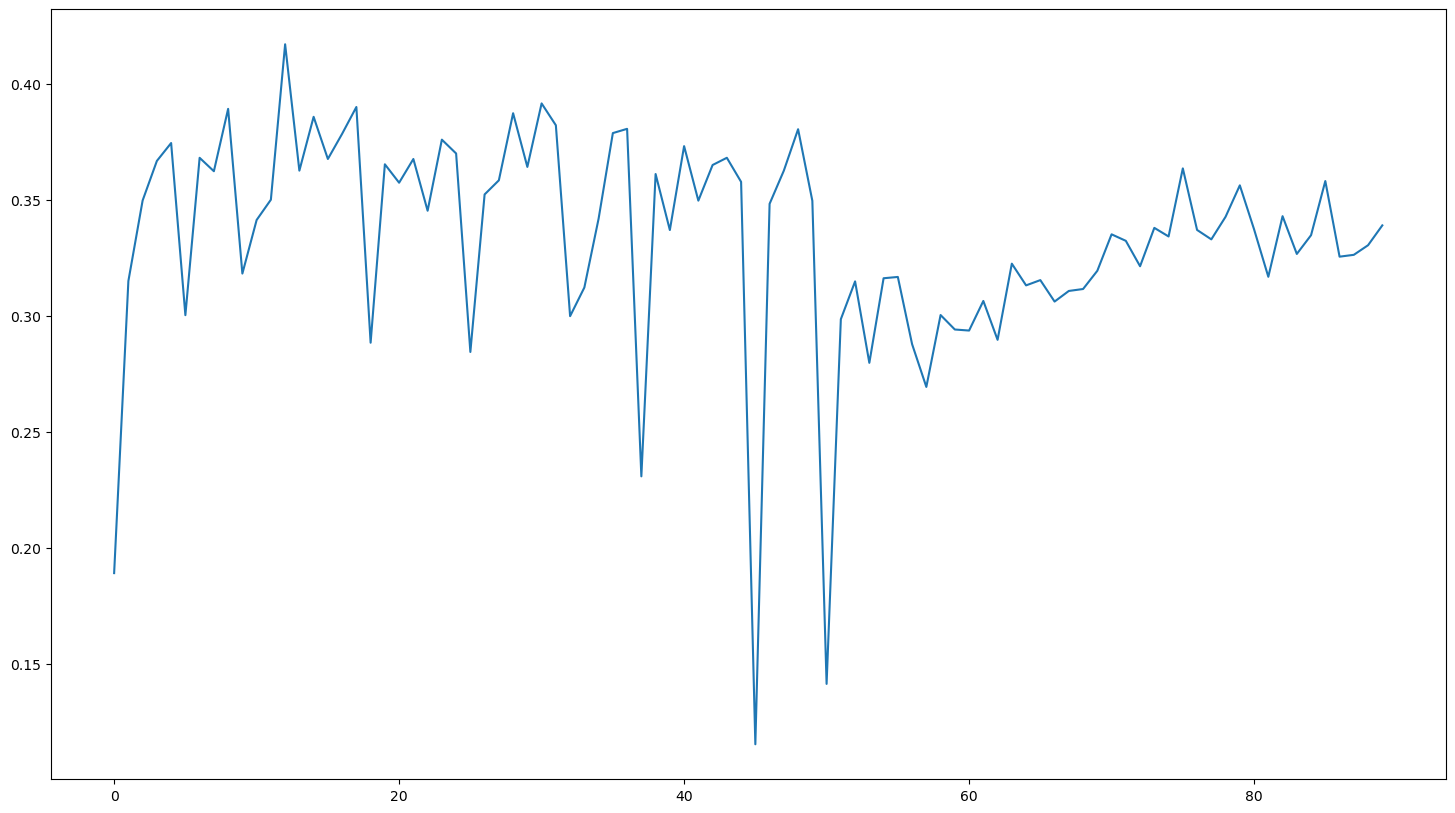

In [182]:
# normalized mutual information
I = np.array(Analytic['Recog_I_Layer_'+str(1)]) + np.array(Analytic['Gen_I_Layer_'+str(1)])
H = np.array(Analytic['Recog_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)])
for i in range(1,n_layer-2):
    I += np.array(Analytic['Recog_I_Layer_'+str(i+1)]) + np.array(Analytic['Gen_I_Layer_'+str(i+1)])
    H += np.array(Analytic['Recog_H_Layer_'+str(i+1)]) + np.array(Analytic['Recog_H_Layer_'+str(i)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(i+1)]) + np.array(Analytic['Gen_H_Layer_'+str(i)])
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(I/H)
plt.show()

In [ ]:
Table = pd.DataFrame(columns=['Algorithm','Normalized_Loss','Normalized_MI'])
Table

In [ ]:
Analytic = Analytic_MNIST0_ws_online_continue
stat = ['WS']

In [ ]:
Loss = 2*np.array(Analytic['Theta_Loss_Layer_'+str(0)])-((np.array(Analytic['Gen_I_Layer_1']))+ \
                                                         np.array(Analytic['Gen_H_Layer_0']))/structure[0]
for i in range(1,n_layer-2):
    Loss += np.array(Analytic['Phi_Loss_Layer_'+str(i)]) + np.array(Analytic['Theta_Loss_Layer_'+str(i)]) - \
    (np.array(Analytic['Gen_I_Layer_'+str(i+1)])+np.array(Analytic['Recog_I_Layer_'+str(i)])+
    np.array(Analytic['Gen_H_Layer_'+str(i)])+np.array(Analytic['Recog_H_Layer_'+str(i)]))/structure[i]/2
Loss += np.array(Analytic['Phi_Loss_Layer_'+str(n_layer-2)]) + np.array(Analytic['Theta_Loss_Layer_'+str(n_layer-2)]) - \
        np.array(Analytic['Recog_I_Layer_'+str(n_layer-2)]+np.array(Analytic['Gen_H_Layer_'+str(n_layer-2)])+ \
                 np.array(Analytic['Recog_H_Layer_'+str(n_layer-2)]))/structure[n_layer-2]/2
stat.append(Loss[-10:].mean())
stat

In [ ]:
I = np.array(Analytic['Recog_I_Layer_'+str(1)]) + np.array(Analytic['Gen_I_Layer_'+str(1)])
H = np.array(Analytic['Recog_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)])
for i in range(1,n_layer-2):
    I += np.array(Analytic['Recog_I_Layer_'+str(i+1)]) + np.array(Analytic['Gen_I_Layer_'+str(i+1)])
    H += np.array(Analytic['Recog_H_Layer_'+str(i+1)]) + np.array(Analytic['Recog_H_Layer_'+str(i)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(i+1)]) + np.array(Analytic['Gen_H_Layer_'+str(i)])
stat.append((I/H)[-10:].mean())
stat

In [ ]:
Table.loc[len(Table)] = stat
Table

In [ ]:
Table.to_csv('Table_MNIST0.csv', index = False)